In [1]:
%run library_utils.ipynb

import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import transformers
assert transformers.__version__ >= '4.17.'
from transformers import (
    AutoTokenizer, 
    AutoModel)
from tqdm import tqdm
from torch import Tensor
import torch.nn as nn

tqdm.pandas()

module = 'go-emotion-pool'
args = load_args(module)

device: cuda


### Tokenizer & Encoder

In [2]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name)
encoder = AutoModel.from_pretrained(args.encoder_name)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
X_tk = tokenize_bert_inputs(
  ['hello my name is jeongwon', 'what are you?'], 
  tokenizer, 
  maxlen=args.sentence_max_len
)
len(X_tk['input_ids'][0])

62

## Loading dataset

In [9]:
%%time
dataset_path = os.path.join(args.output_dir, args.train_dataset_path)
assert os.path.exists(dataset_path)

train_dataset, val_dataset = generate_bert_dataset(
    dataset_path,     
    tokenizer, 
    emotions = args.emotions, 
    sentence_max_len = args.sentence_max_len, 
    split = args.validation_split_from_train
)

Wall time: 5.74 s


## Building Model

In [10]:
class GoEmotionPoolClassifer(TransformerEncoderBase):
    def __init__(self, 
        encoder, 
        criterion = nn.BCEWithLogitsLoss(), 
        hiddens = None, 
        dropout_p: float = 0.1, 
        n_cls:int = 28
    ) -> None:
        config = {
            'hiddens':  [100] if hiddens is None else hiddens, 
            'dropout_p': dropout_p, 
            'n_cls': n_cls
        }
        super().__init__(encoder, criterion, config)

        # new layers 
        self.dropout = nn.Dropout(dropout_p)

        # full connected
        fcs = []
        in_feature = self.encoder_dim 
        for h in self.config['hiddens']:
            fcs.append(nn.Linear(in_feature, h))
            fcs.append(nn.ReLU())
            in_feature = h    

        # final layer 
        fcs.append(nn.Linear(in_feature, n_cls))
        self.fcs = nn.Sequential(*fcs)

    def forward(self, input_ids, attention_mask, y_true=None):
        encoder_output = super().forward(input_ids, attention_mask)
        pool_output = encoder_output['pooler_output']

        z = self.dropout(pool_output)
        logits = self.fcs(z)

        if y_true is not None:
            loss = self.criterion(logits, y_true)
            return (loss, logits)

        return logits

In [11]:
def create_go_emotion_pool(args, encoder):
    return GoEmotionPoolClassifer(
        encoder, 
        hiddens = args.fc_hiddens, 
        dropout_p = args.dropout_p, 
        n_cls = len(args.emotions)
    )

model = create_go_emotion_pool(args, encoder)
model

GoEmotionPoolClassifer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise

## Utility to predict on examples

In [12]:
def proba_on_examples(texts, model):
    X_tk = tokenize_bert_inputs(
        texts, tokenizer, maxlen = args.sentence_max_len
    )
    X_tk['input_ids'] = Tensor(X_tk['input_ids']).type(torch.int32)
    X_tk['attention_mask'] = Tensor(X_tk['attention_mask']).type(torch.int32)
    proba = predict_proba_examples(X_tk, model)
    return proba

In [13]:
proba = proba_on_examples(['hello my name is jeongwon', 'nice to meet you!'], model)
proba_to_emotion(
    proba,
    args.classification_threshold, 
    args.emotions, 
)[0][:3]

[('admiration', 0.49230123), ('amusement', 0.4909365), ('anger', 0.46930766)]

In [15]:
proba = predict_proba_examples(val_dataset[:5], model)
y_true = val_dataset[:5]['y_true'].numpy()
compute_classification_metrics(y_true, proba, 0.1)

{'loss': 0.6985663875136744,
 'trigger_rate': 1.0,
 'accuracy': 0.04695688599307007,
 'macro_precision': 0.04695688599307007,
 'macro_recall': 1.0,
 'macro_f1': 0.0882997470479051,
 'micro_precision': 0.04695688599307007,
 'micro_recall': 1.0,
 'micro_f1': 0.0897016613029486,
 'weighted_precision': 0.0643399480933103,
 'weighted_recall': 1.0,
 'weighted_f1': 0.11955701106465137}

In [11]:
# testing evaluate
# evaluate(
#     model, 
#     val_dataset, 
#     batch_size = args.eval_batch_size, 
#     threshold = args.classification_threshold, 
#     device = args.device
# )

# testing saving
# model = create_go_emotion_pool(args, encoder)
# _ = save_checkpoint(
#     model, 
#     args.output_dir, 
#     model_name='testmodel',
#     metadata=args
# )

# model_copy, _ = load_from_checkpoint(
#     args.output_dir,
#     model_name='testmodel',
#     checkpoint_id='null-model', 
#     model_cls=GoEmotionPoolClassifer
# )

# check_model_same(model, model_copy)

True

In [17]:
# clear_archive(args.output_dir, args.model_name)

In [18]:
model = create_go_emotion_pool(args, encoder)
model, metadata = train(
    model, 
    train_dataset, 
    val_dataset, 
    dict(args), 
    tokenizer, 
    epochs=args.train_epochs, 
    train_batch_size = args.train_batch_size, 
    val_batch_size = args.eval_batch_size, 
    save_steps = args.save_steps, 
    validation_steps= args.validation_steps, 
    archive_dir = args.output_dir, 
    model_name = args.model_name, 
    classification_threshold = args.classification_threshold, 
    learning_rate = args.learning_rate, 
    grad_clip_max = args.grad_clip_max, 
    weight_decay = args.weight_decay, 
    warmup_ratio = args.warmup_ratio, 
    logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
    continue_training=False,
    device = args.device
)

C:\Users\dumps\anaconda3\envs\emotion-detection\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


training epoch 0


Training:  49%|████▉     | 3002/6101 [00:57<28:07,  1.84it/s]

evaluating at step 3000
val {'macro_precision': 0.021635166289512068, 'macro_recall': 0.4074074074074074, 'macro_f1': 0.04019825305989202}
tr {'macro_precision': 0.023459970509150836, 'macro_recall': 0.40742461792647666, 'macro_f1': 0.041089064022812476}
saving at step 3000


Training:  98%|█████████▊| 6006/6101 [01:53<00:50,  1.89it/s]

evaluating at step 6000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 6000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 53.05it/s]


training epoch 1


Training:  48%|████▊     | 2902/6101 [00:53<30:42,  1.74it/s]

evaluating at step 9000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 9000


Training:  97%|█████████▋| 5906/6101 [01:49<01:13,  2.67it/s]

evaluating at step 12000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 12000


Training: 100%|██████████| 6101/6101 [01:52<00:00, 54.09it/s]


training epoch 2


Training:  46%|████▌     | 2805/6101 [00:53<25:15,  2.17it/s]

evaluating at step 15000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 15000


Training:  95%|█████████▌| 5798/6101 [01:52<03:23,  1.49it/s]

evaluating at step 18000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 18000


Training: 100%|██████████| 6101/6101 [01:56<00:00, 52.16it/s]


training epoch 3


Training:  44%|████▍     | 2701/6101 [00:52<30:16,  1.87it/s]

evaluating at step 21000
val {'macro_precision': 0.047518366912105155, 'macro_recall': 0.020835387295014624, 'macro_f1': 0.0237853892985557}
tr {'macro_precision': 0.04727227454582774, 'macro_recall': 0.020715992253589104, 'macro_f1': 0.02337790950306398}
saving at step 21000


Training:  93%|█████████▎| 5702/6101 [01:50<03:45,  1.77it/s]

evaluating at step 24000
val {'macro_precision': 0.10852281258102103, 'macro_recall': 0.08159485190116167, 'macro_f1': 0.08892460621675465}
tr {'macro_precision': 0.10615432770923008, 'macro_recall': 0.08037050885610719, 'macro_f1': 0.08727564282953229}
saving at step 24000


Training: 100%|██████████| 6101/6101 [01:56<00:00, 52.18it/s]


training epoch 4


Training:  43%|████▎     | 2595/6101 [00:38<00:51, 68.53it/s]

evaluating at step 27000
val {'macro_precision': 0.12149281085524563, 'macro_recall': 0.09065002013105548, 'macro_f1': 0.09829595874964658}
tr {'macro_precision': 0.12440238869787093, 'macro_recall': 0.09068367829182689, 'macro_f1': 0.09901002965454277}
saving at step 27000


Training:  92%|█████████▏| 5596/6101 [01:47<04:33,  1.85it/s]

evaluating at step 30000
val {'macro_precision': 0.12435272545989405, 'macro_recall': 0.10904106904189714, 'macro_f1': 0.11517152345773266}
tr {'macro_precision': 0.12337773762053317, 'macro_recall': 0.10862589577599709, 'macro_f1': 0.11447274071465756}
saving at step 30000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 52.94it/s]


training epoch 5


Training:  41%|████      | 2497/6101 [00:49<32:53,  1.83it/s]

evaluating at step 33000
val {'macro_precision': 0.12126501939994713, 'macro_recall': 0.11568297988835233, 'macro_f1': 0.11801193259910008}
tr {'macro_precision': 0.12193172858015178, 'macro_recall': 0.1150517168019506, 'macro_f1': 0.11801691874855703}
saving at step 33000


Training:  90%|████████▉ | 5489/6101 [01:33<00:09, 62.82it/s]

evaluating at step 36000
val {'macro_precision': 0.21503358717578444, 'macro_recall': 0.11930349686002059, 'macro_f1': 0.12814532269193704}
tr {'macro_precision': 0.1898149318284035, 'macro_recall': 0.11880260453882506, 'macro_f1': 0.1272353099019655}
saving at step 36000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 52.87it/s]


training epoch 6


Training:  39%|███▉      | 2394/6101 [00:47<38:57,  1.59it/s]

evaluating at step 39000
val {'macro_precision': 0.23360668084039948, 'macro_recall': 0.13375705827830586, 'macro_f1': 0.14563231354478653}
tr {'macro_precision': 0.22648458276205513, 'macro_recall': 0.1335003013726192, 'macro_f1': 0.1449939935116795}
saving at step 39000


Training:  88%|████████▊ | 5395/6101 [01:45<06:16,  1.88it/s]

evaluating at step 42000
val {'macro_precision': 0.3045750369162191, 'macro_recall': 0.15250859013156326, 'macro_f1': 0.17071564493913488}
tr {'macro_precision': 0.30681202897340637, 'macro_recall': 0.15178643088742344, 'macro_f1': 0.16910083766379724}
saving at step 42000


Training: 100%|██████████| 6101/6101 [01:55<00:00, 52.76it/s]


training epoch 7


Training:  38%|███▊      | 2297/6101 [00:45<33:48,  1.88it/s]

evaluating at step 45000
val {'macro_precision': 0.3168123779363948, 'macro_recall': 0.16764975526639236, 'macro_f1': 0.1964123880497086}
tr {'macro_precision': 0.3279563781243489, 'macro_recall': 0.17456974204064465, 'macro_f1': 0.20496231628544545}
saving at step 45000


Training:  87%|████████▋ | 5293/6101 [01:42<07:54,  1.70it/s]

evaluating at step 48000
val {'macro_precision': 0.3342380029109521, 'macro_recall': 0.18188232961555956, 'macro_f1': 0.20819911899532226}
tr {'macro_precision': 0.3886078595770884, 'macro_recall': 0.18825866672757396, 'macro_f1': 0.21589535756029446}
saving at step 48000


Training: 100%|██████████| 6101/6101 [01:54<00:00, 53.41it/s]


training epoch 8


Training:  36%|███▌      | 2198/6101 [00:43<34:33,  1.88it/s]

evaluating at step 51000
val {'macro_precision': 0.3408870210079305, 'macro_recall': 0.18853876130977218, 'macro_f1': 0.2237701366110899}
tr {'macro_precision': 0.4246489984640806, 'macro_recall': 0.20074458972298304, 'macro_f1': 0.2383933336253146}
saving at step 51000


Training:  85%|████████▌ | 5195/6101 [01:40<08:30,  1.78it/s]

evaluating at step 54000
val {'macro_precision': 0.3697979591263244, 'macro_recall': 0.2136148170187514, 'macro_f1': 0.24561549634929772}
tr {'macro_precision': 0.3926096892289464, 'macro_recall': 0.22737236776292372, 'macro_f1': 0.2621096048571388}
saving at step 54000


Training: 100%|██████████| 6101/6101 [01:54<00:00, 53.12it/s]


training epoch 9


Training:  34%|███▍      | 2091/6101 [00:43<40:17,  1.66it/s]

evaluating at step 57000
val {'macro_precision': 0.4081262036600162, 'macro_recall': 0.2144567783662476, 'macro_f1': 0.24663056075507564}
tr {'macro_precision': 0.41331366420716337, 'macro_recall': 0.2364314002864458, 'macro_f1': 0.2737564025791662}
saving at step 57000


Training:  83%|████████▎ | 5092/6101 [01:42<09:29,  1.77it/s]

evaluating at step 60000
val {'macro_precision': 0.3945782620992259, 'macro_recall': 0.22327258326063365, 'macro_f1': 0.2579048482564836}
tr {'macro_precision': 0.43463839478719524, 'macro_recall': 0.24429190636570938, 'macro_f1': 0.2830408938147957}
saving at step 60000


Training: 100%|██████████| 6101/6101 [01:58<00:00, 51.63it/s]


In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

df = get_attrs_from_checkpoints_meta(args.output_dir, args.model_name, [
    'tr_metrics.loss', 
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
])
df.head(3)

,tr_metrics.loss,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
0,0.519420,0.519514,0.407454,0.588859,0.040198,0.095223,3000
1,0.209588,0.209275,0.000000,0.953043,0.000000,0.000000,6000
2,0.181303,0.180625,0.000000,0.953043,0.000000,0.000000,9000


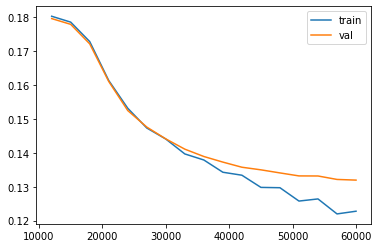

In [26]:
plt.plot(df['checkpoint_id'][3:], df['tr_metrics.loss'][3:], label='train')
plt.plot(df['checkpoint_id'][3:], df['val_metrics.loss'][3:], label='val')
plt.legend()

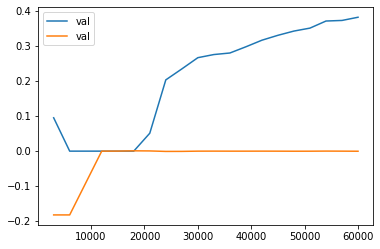

In [27]:
plt.plot(df['checkpoint_id'], df['val_metrics.micro_f1'], label='val')
plt.plot(df['checkpoint_id'], 
np.gradient(np.gradient(df['val_metrics.accuracy'])), label='val')
plt.legend()

## Checking final model 


In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

model, meta = load_from_checkpoint(
    args.output_dir, 
    args.model_name, 
    checkpoint_id='3000', 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionPoolClassifer
)

proba = predict_proba(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    device = args.device
)
y_true = val_dataset[:]['y_true'].numpy()

val_final = compute_classification_metrics(y_true, proba, threshold=args.classification_threshold)
print(val_final)

for i, emt in enumerate(args.emotions):
    fpr, tpr, _ = roc_curve(y_true[:, i], proba[:, i])
    plt.plot(fpr, tpr)
    plt.title(emt)
    plt.show()


In [ ]:
proba_to_emotion(
    proba_on_examples([
        'fuck cloud', 
        'yeet'
    ], model), 
    0.4, 
    args.emotions)